# Glorious Melee Combat

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from fractions import Fraction
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

In [3]:
### Irrelevant really
### A small utility function for converting fractions to dice rolls
def fraction_to_roll(fraction):
    if fraction == 0:
        return "-"
    return {Fraction(n, 6): "{}+".format(7-n) for n in range(1, 6)}.get(fraction)

## Understanding Melee Combat

Tabletop Warhammer has 3 stats relevant to melee combat
1. Weapon Skill (WS) - How good you are at hitting or avoiding being hit
2. Strength (S) - How hard you hit
3. Toughness (T) - How hard you are

There are also 2 additional modifiers that come into play
1. Save - Usually from armour your unit is wearing
2. Ward - Rare magical/intrinsic protection

All these stats result in rolls of a D6 combined with the special rule, 1s _always_ fail, 6s _always_ succeed.

### Roll to Hit

__How likely are you to hit your opponent?__

Weapon Skill comparisons between Attackers and Defenders is not symmetric

The Attackers WS is compared to the Defenders WS, 
- If they're the same, there's a 1/2 chance to hit (4+)
- If the Attacker's WS is greater, there's a 2/3 chance to hit (3+)
- If the Attacker's WS is greater than twice the Defender's WS, there's a 5/6 chance to hit (2+)

On the other hand
- If the Defender's WS is greater, there's a 1/2 chance to hit (4+)
- If the Defender's WS is greater than twice the Attacker's WS, there's a 1/3 chance to hit (5+)
- If the Defender's WS is greater than twice the Attacker's WS + 3, there's a 1/6 chance to hit (6+)

In [4]:
def roll_to_hit(attackers_ws, defenders_ws):
    
    if defenders_ws < attackers_ws:
        if defenders_ws*2 < attackers_ws:
            return Fraction(5, 6)
        return Fraction(4, 6)
    
    if attackers_ws < defenders_ws:
        if attackers_ws*2 < defenders_ws:
            if attackers_ws*2+3 < defenders_ws:
                return Fraction(1, 6)
            return Fraction(2, 6)
        return Fraction(3, 6)
    
    return Fraction(3, 6)

In [5]:
to_hit_table = (pd.DataFrame([(a, d, roll_to_hit(a, d)) for a in range(1, 11) for d in range(1, 11)],
                             columns=["attacker_ws", "defender_ws", "to_hit"])
                .set_index(["attacker_ws", "defender_ws"]))

print(len(to_hit_table))
to_hit_table.loc[[(3, 1), (3, 2), (1, 6), (1, 3), (1, 2), (3, 3)]].sort_index()

100


to_hit
attacker_ws defender_ws       
1           2              1/2
            3              1/3
            6              1/6
3           1              5/6
            2              2/3
            3              1/2

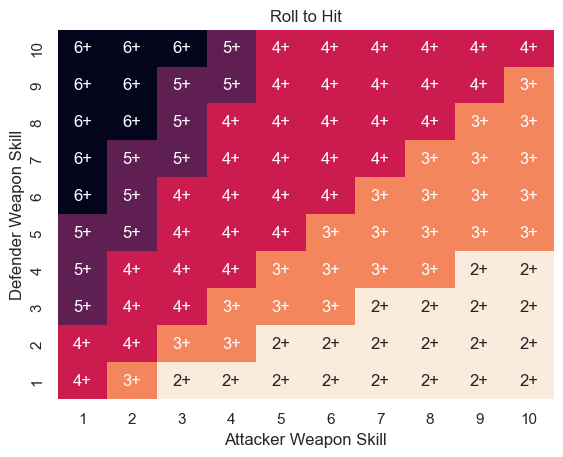

In [6]:
data = (to_hit_table
        .pivot_table(index="defender_ws", columns="attacker_ws", values="to_hit")
        .sort_index(ascending=False))

annot = (to_hit_table
         .assign(label=to_hit_table["to_hit"].apply(fraction_to_roll))
         .reset_index()
         .pivot(index="defender_ws", columns="attacker_ws", values="label")
         .sort_index(ascending=False))

f, ax = plt.subplots(1, 1)
sns.heatmap(data, annot=annot.values, ax=ax, fmt="", cbar=False)
ax.set_title("Roll to Hit")
ax.set_xlabel("Attacker Weapon Skill")
ax.set_ylabel("Defender Weapon Skill");

### Roll to Wound

__If you actually hit, how likely are you to do any damage?__

In this case you compare Attacker's S vs Defender's T and the comparison is simpler and symmetric.

- If they're the same, there's a 1/2 chance to wound (4+)
- If the Attacker's S is 1 higher, there's a 2/3 chance to wound (3+)
- If the Attacker's S is even higher, there's a 5/6 chance to wound (2+)

Similarly

- If the Defender's T is 1 higher, there's a 1/3 chance to wound (5+)
- If the Defender's T is even higher, there's a 1/6 chance to wound (6+)

In [7]:
def roll_to_wound(attackers_s, defenders_t):

    if defenders_t < attackers_s:
        if (attackers_s - defenders_t) > 1:
            return Fraction(5, 6)
        return Fraction(4, 6)
    
    if attackers_s < defenders_t:
        if (defenders_t - attackers_s) > 1:
            return Fraction(1, 6)
        return Fraction(2, 6)
    
    return Fraction(3, 6)

In [8]:
to_wound_table = (pd.DataFrame([(a, d, roll_to_wound(a, d)) for a in range(1, 11) for d in range(1, 11)],
                               columns=["attacker_s", "defender_t", "to_wound"])
                  .set_index(["attacker_s", "defender_t"]))

print(len(to_wound_table))
to_wound_table.loc[[(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]]

100


to_wound
attacker_s defender_t         
3          1               5/6
           2               2/3
           3               1/2
           4               1/3
           5               1/6

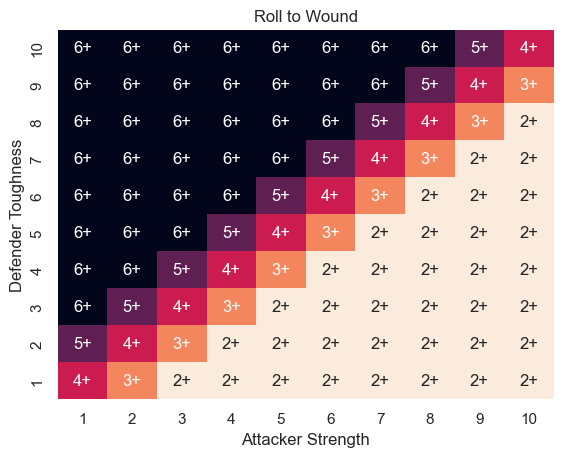

In [9]:
data = (to_wound_table
        .pivot_table(index="defender_t", columns="attacker_s", values="to_wound")
        .sort_index(ascending=False))

annot = (to_wound_table
         .assign(label=to_wound_table["to_wound"].apply(fraction_to_roll))
         .reset_index()
         .pivot(index="defender_t", columns="attacker_s", values="label")
         .sort_index(ascending=False))

f, ax = plt.subplots(1, 1)
sns.heatmap(data, annot=annot, ax=ax, fmt="", cbar=False)
ax.set_title("Roll to Wound")
ax.set_xlabel("Attacker Strength")
ax.set_ylabel("Defender Toughness");

### Roll to Save

__Does your armour help?__

Save rolls only happen if the unit is wearing any armour and it can be negated by the strength of the attack.

All armour values are combined into a single `Save Bonus`, for example
- `Light Armour` gives you a `+1`, 
- Carrying a `Shield` also gives you a `+1`
- Both will give you `+2`

On the other hand, a strong attack can ignore armour, every point of strength above 3 (most humans) results in a `-1` armour modifier.

If you have no (or a negative) armour modifier, you do not make a save roll

In [10]:
def roll_to_save(attackers_s, defenders_save):

    final_save = defenders_save
    
    if attackers_s > 3:
        final_save = defenders_save - (attackers_s - 3)
        
    if final_save < 1:
        return 0

    if final_save > 4:
        return Fraction(5, 6)
    
    return Fraction(final_save, 6)

In [11]:
to_save_table = (pd.DataFrame([(a, save, roll_to_save(a, save)) for a in range(1, 11) for save in range(0, 13)],
                              columns=["attacker_s", "defender_save", "to_save"])
                 .set_index(["attacker_s", "defender_save"]))

print(len(to_save_table))
to_save_table.loc[[(3, 0), (3, 1), (3, 2), (4, 2), (5, 2)]]

130


to_save
attacker_s defender_save        
3          0                   0
           1                 1/6
           2                 1/3
4          2                 1/6
5          2                   0

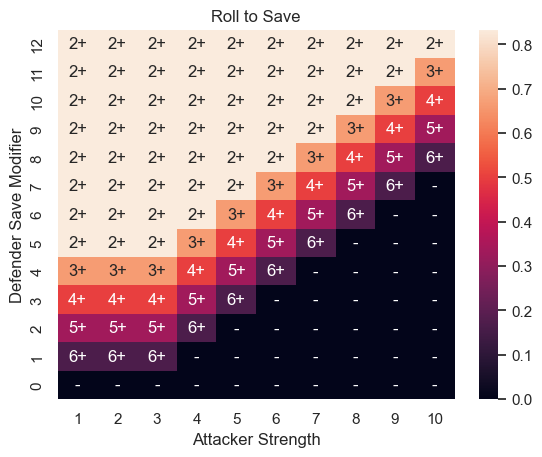

In [12]:
data = (to_save_table
        .pivot_table(index="defender_save", columns="attacker_s", values="to_save")
        .sort_index(ascending=False))

annot = (to_save_table
         .assign(label=to_save_table["to_save"].apply(fraction_to_roll))
         .reset_index()
         .pivot(index="defender_save", columns="attacker_s", values="label")
         .sort_index(ascending=False))

f, ax = plt.subplots(1, 1)
sns.heatmap(data, annot=annot, ax=ax, fmt="")
ax.set_title("Roll to Save")
ax.set_xlabel("Attacker Strength")
ax.set_ylabel("Defender Save Modifier");

### Roll to Ward

__Do you have the favour of a friendly wizard?__

Some special items, often magical, give you an additional saving roll called a ward roll.

A ward save is unaffected by attack strength but can also never be improved above 1/2 chance to save (4+).

Breaking the convention so far, ward saves are also not tied to stats but directly written down as rolls, 
`Amulet (6+)` for example

In [13]:
# Treating a Ward of 7 as -
def roll_to_ward(defenders_ward):
    
    if defenders_ward < 4:
        return Fraction(3, 6)
    
    return Fraction(7 - defenders_ward, 6)

In [14]:
to_ward_table = (pd.DataFrame([(w, roll_to_ward(w)) for w in range(1, 8)],
                              columns=["ward", "to_ward"])
                 .set_index("ward"))

print(len(to_ward_table))
to_ward_table.loc[[3, 4, 5, 6, 7]]

7


,to_ward
ward,
3,1/2
4,1/2
5,1/3
6,1/6
7,0


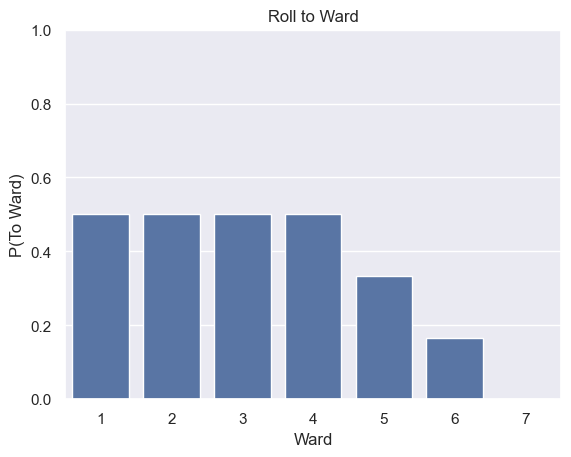

In [15]:
f, ax = plt.subplots(1, 1)

sns.barplot(data=to_ward_table.reset_index(), x="ward", y="to_ward", color="C0")
ax.set_ylim(0, 1)
ax.set_title("Roll to Ward")
ax.set_xlabel("Ward")
ax.set_ylabel("P(To Ward)")
ax.set_xticklabels("{}".format(w) for w in range(1, 8));

### P(Wound)

In the end the probability to wound a defender with a single attack

`P(to Hit) * P(to Wound) * (1 - P(to Save)) * (1 - P(to Ward))`

In [16]:
def p_wound(a_ws, d_ws, a_s, d_t, d_save=0, d_ward=7):
    p_hit = roll_to_hit(a_ws, d_ws)
    p_wound = roll_to_wound(a_s, d_t)
    p_save = roll_to_save(a_s, d_save)
    p_ward = roll_to_ward(d_ward)
    p = p_hit * p_wound * (1-p_save) * (1-p_ward)
    return p

So a simple Empire Spearman attacking one from another State with `WS 3`, `S 3`, `T 3`, no armour and no magical items has a 1/4 chance of wounding his opponent.

In [17]:
p_wound(3, 3, 3, 3)

Fraction(1, 4)

### But which stats are most important?

Should I care more about Weapon Skill? Strength?

What about if I'm defending, do I want to invest in that magical trinket or another piece of armour?

#### The Linear Model

Fitting a model to the predict P(wound) might help with an answer, the underlying model is non-linear with lots of jumps but it might be good enough for an approximation.

In [18]:
p_wound_table = (pd.DataFrame([(a_ws, d_ws, a_s, d_t, d_save, d_ward, p_wound(a_ws, d_ws, a_s, d_t, d_save, d_ward))
                               for a_ws in range(1, 11)
                               for d_ws in range(1, 11)
                               for a_s in range(1, 11)
                               for d_t in range(1, 11)
                               for d_save in range(0, 13)
                               for d_ward in range(1, 8)],
                              columns=["a_ws", "d_ws", "a_s", "d_t", "d_save", "d_ward", "p_wound"])
                 .set_index(["a_ws", "d_ws", "a_s", "d_t", "d_save", "d_ward"]))

print(len(p_wound_table))
p_wound_table[:3]

910000


p_wound
a_ws d_ws a_s d_t d_save d_ward        
1    1    1   1   0      1          1/8
                         2          1/8
                         3          1/8

In [19]:
X = (p_wound_table.reset_index()[["a_ws", "d_ws", "a_s", "d_t", "d_save", "d_ward"]])
X = sm.add_constant(X)
y = p_wound_table.reset_index()["p_wound"].astype(float)

In [20]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                p_wound   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                 2.805e+05
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:31:25   Log-Likelihood:             1.0665e+06
No. Observations:              910000   AIC:                        -2.133e+06
Df Residuals:                  909993   BIC:                        -2.133e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0771      0.000    208.220      0.0

##### Conclusions

It looks pretty good
- Attacker's WS is more important than Defender's WS, since it's asymmetric
- Attacker's S is more important than Defender's T, since it breaks through armour
- `d_ward` has a positive effect on P(wound) while `d_save` is negative

### Simulating the World

But I have the underlying model, I don't need to approximate it linearly. For every combination of stats I have the exact probability of a wound.

The linear model is calculating the average change in damage for a 1 unit change in the underlying stat, I can calculate that precisely and see how much it diverges from the linear model's predictions.

In [21]:
# a_ws
a_ws_increments = []
for a_ws in range(2, 11):    
    diff = p_wound_table.loc[pd.IndexSlice[a_ws], "p_wound"] -\
           p_wound_table.loc[pd.IndexSlice[a_ws-1], "p_wound"]
    a_ws_increments.append(diff.values)

a_ws_increments = np.concatenate(a_ws_increments)
print(float(a_ws_increments.mean()))

0.009236111111111112


In [22]:
# d_ws
d_ws_increments = []
for d_ws in range(2, 11):    
    diff = p_wound_table.loc[pd.IndexSlice[:, d_ws], ["p_wound"]].reset_index(level=1) -\
           p_wound_table.loc[pd.IndexSlice[:, d_ws-1], ["p_wound"]].reset_index(level=1)
    d_ws_increments.append(diff["p_wound"])

d_ws_increments = np.concatenate(d_ws_increments)
print(float(d_ws_increments.mean()))

-0.008525641025641026


In [23]:
# a_s
a_s_increments = []
for a_s in range(2, 11):
    diff = p_wound_table.loc[pd.IndexSlice[:, :, a_s], ["p_wound"]].reset_index(level=2) -\
           p_wound_table.loc[pd.IndexSlice[:, :, a_s-1], ["p_wound"]].reset_index(level=2)
    a_s_increments.append(diff["p_wound"])

a_s_increments = np.concatenate(a_s_increments)
print(float(a_s_increments.mean()))

0.022196581196581196


In [24]:
# d_t
d_t_increments = []
for d_t in range(2, 11):
    diff = p_wound_table.loc[pd.IndexSlice[:, :, :, d_t], ["p_wound"]].reset_index(level=3) -\
           p_wound_table.loc[pd.IndexSlice[:, :, :, d_t-1], ["p_wound"]].reset_index(level=3)
    d_t_increments.append(diff["p_wound"])

d_t_increments = np.concatenate(d_t_increments)
print(float(d_t_increments.mean()))

-0.01206837606837607


In [25]:
# d_save
d_save_increments = []
for d_save in range(1, 13):
    diff = p_wound_table.loc[pd.IndexSlice[:, :, :, :, d_save], ["p_wound"]].reset_index(level=4) -\
           p_wound_table.loc[pd.IndexSlice[:, :, :, :, d_save-1], ["p_wound"]].reset_index(level=4)
    d_save_increments.append(diff["p_wound"])

d_save_increments = np.concatenate(d_save_increments)
print(float(d_save_increments.mean()))

-0.0125


In [26]:
# d_ward
d_ward_increments = []
for d_ward in range(2, 8):
    diff = p_wound_table.loc[pd.IndexSlice[:, :, :, :, :, d_ward], ["p_wound"]].reset_index(level=5) -\
           p_wound_table.loc[pd.IndexSlice[:, :, :, :, :, d_ward-1], ["p_wound"]].reset_index(level=5)
    d_ward_increments.append(diff["p_wound"])

d_ward_increments = np.concatenate(d_ward_increments)
print(float(d_ward_increments.mean()))

0.013925213675213675


In [27]:
(pd.DataFrame(results.params, columns=["OLS"])
 .join(results.conf_int().rename(columns={0: "[0.025", 1: "0.975]"}))
 .assign(ideal=[np.nan, a_ws_increments.mean(), d_ws_increments.mean(), a_s_increments.mean(),
                d_t_increments.mean(), d_save_increments.mean(), d_ward_increments.mean()])
 .assign(ideal=lambda df: df["ideal"].astype(float))
 .assign(is_within_bounds=lambda df: ((df["ideal"] < df["0.975]"]) &\
                                      (df["[0.025"] < df["ideal"])) |\
                                     ((df["0.975]"] < df["ideal"]) &\
                                      (df["ideal"] < df["[0.025"])))
 .assign(abs_error=lambda df: df["OLS"] - df["ideal"])
 .assign(rel_error_perc=lambda df: (df["ideal"] - df["OLS"])/df["ideal"]*100))

,OLS,[0.025,0.975],ideal,is_within_bounds,abs_error,rel_error_perc
const,0.077145,0.076419,0.077871,NaN,False,NaN,NaN
a_ws,0.008836,0.008782,0.008889,0.009236,False,-4.004468e-04,4.335664e+00
d_ws,-0.008526,-0.008579,-0.008472,-0.008526,True,9.246076e-15,1.084502e-10
a_s,0.022854,0.022800,0.022907,0.022197,False,6.570319e-04,-2.960059e+00
d_t,-0.012345,-0.012399,-0.012292,-0.012068,False,-2.770785e-04,-2.295905e+00
d_save,-0.014154,-0.014195,-0.014113,-0.012500,False,-1.653846e-03,-1.323077e+01
d_ward,0.013925,0.013848,0.014002,0.013925,True,-1.314920e-15,9.442730e-12


##### Conclusions

In almost all cases, the real mean falls outside the bounds of the predicted mean but the absolute errors are quite small so I still think it's a pretty good model fit.